In [ ]:
# Step 1: Uninstall EVERYTHING causing conflict
#!pip uninstall -y fsspec gcsfs datasets

# Step 2: Install versions that work well together
#!pip install -q fsspec==2023.12.1 gcsfs==2023.12.1 datasets==2.19.1

# Step 3: Continue with the rest
#!pip install -q transformers timm kagglehub torchvision


Found existing installation: fsspec 2025.3.2
Uninstalling fsspec-2025.3.2:
  Successfully uninstalled fsspec-2025.3.2
Found existing installation: gcsfs 2025.3.2
Uninstalling gcsfs-2025.3.2:
  Successfully uninstalled gcsfs-2025.3.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.9/168.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 

In [ ]:
import os
import torch
import numpy as np
import torchvision.transforms as T
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import ImageFolder
from transformers import ViTForImageClassification, AutoImageProcessor, TrainingArguments, Trainer, default_data_collator
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
dataset_path = "/content/drive/MyDrive/Wheat Disease Dataset"

In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])


In [ ]:
# 📚 IMPORTS
import os
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
import timm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

full_dataset = ImageFolder(dataset_path, transform=transform)
class_names = full_dataset.classes
num_classes = len(class_names)

# 🔀 SPLIT DATA
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model('cait_s24_224', pretrained=True, num_classes=num_classes)
model = model.to(device)

# ⚙️ LOSS + OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=2e-4, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/188M [00:00<?, ?B/s]

In [ ]:
epochs = 15
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/15 - Loss: 1.5417
Epoch 2/15 - Loss: 1.2977
Epoch 3/15 - Loss: 0.8874
Epoch 4/15 - Loss: 0.7326
Epoch 5/15 - Loss: 0.4984
Epoch 6/15 - Loss: 0.3969
Epoch 7/15 - Loss: 0.3281
Epoch 8/15 - Loss: 0.2503
Epoch 9/15 - Loss: 0.2003
Epoch 10/15 - Loss: 0.1697
Epoch 11/15 - Loss: 0.1714
Epoch 12/15 - Loss: 0.1542
Epoch 13/15 - Loss: 0.1808
Epoch 14/15 - Loss: 0.1518
Epoch 15/15 - Loss: 0.2029


In [ ]:
model.eval()
all_preds, all_labels = [], []

In [ ]:
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

In [ ]:
accuracy = accuracy_score(all_labels, all_preds)
print(f"\n✅ Overall Validation Accuracy: {accuracy * 100:.2f}%")
print("\n📊 Classification Report:\n", classification_report(all_labels, all_preds, target_names=class_names))


✅ Overall Validation Accuracy: 91.09%

📊 Classification Report:
               precision    recall  f1-score   support

   BrownRust       0.93      0.97      0.95        29
     Healthy       0.94      0.85      0.89        20
      Mildew       0.86      0.86      0.86        29
    Septoria       0.96      0.93      0.94        70
  YellowRust       0.86      0.91      0.88        54

    accuracy                           0.91       202
   macro avg       0.91      0.90      0.91       202
weighted avg       0.91      0.91      0.91       202



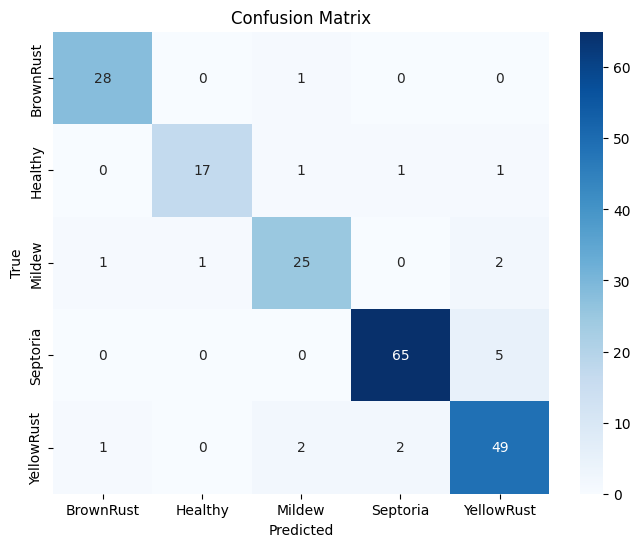

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
!pip install -q gradio

import gradio as gr
from PIL import Image

# Load class names from dataset
class_names = full_dataset.classes

# Define a prediction function
def predict_image(img):
    model.eval()
    img = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(img)
        probs = torch.nn.functional.softmax(outputs[0], dim=0)
    top_class = torch.argmax(probs).item()
    return {class_names[i]: float(probs[i]) for i in range(len(class_names))}

# Gradio Interface
interface = gr.Interface(fn=predict_image,
                         inputs=gr.Image(type="pil"),
                         outputs=gr.Label(num_top_classes=5),
                         title="Wheat Disease Classifier (CaiT)",
                         description="Upload a leaf image to detect wheat disease using a CaiT Transformer model.")

interface.launch(debug=True)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 105.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.0 MB/s eta 0:00:00
Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://486a2d82c2e8a92118.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deplo

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://486a2d82c2e8a92118.gradio.live


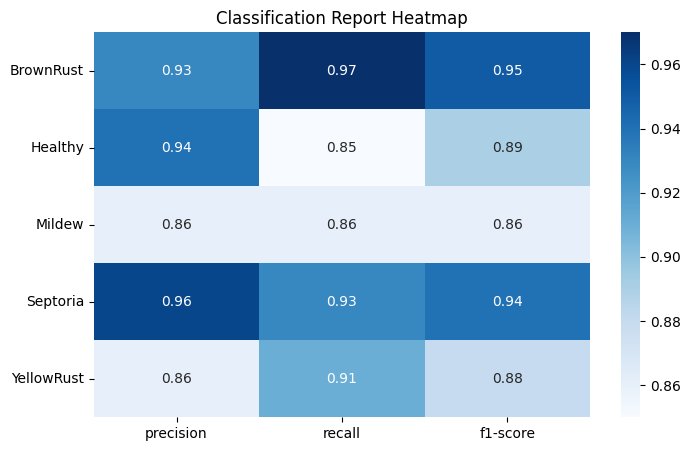

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

# Simulated values from your classification report
report_dict = {
    "BrownRust": {"precision": 0.93, "recall": 0.97, "f1-score": 0.95},
    "Healthy": {"precision": 0.94, "recall": 0.85, "f1-score": 0.89},
    "Mildew": {"precision": 0.86, "recall": 0.86, "f1-score": 0.86},
    "Septoria": {"precision": 0.96, "recall": 0.93, "f1-score": 0.94},
    "YellowRust": {"precision": 0.86, "recall": 0.91, "f1-score": 0.88},
}

# Convert dictionary to DataFrame
df = pd.DataFrame(report_dict).T
df = df.round(2)  # Optional: round to 2 decimal places

# Plot the heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(df, annot=True, cmap="Blues", fmt=".2f", cbar=True)
plt.title("Classification Report Heatmap")
plt.yticks(rotation=0)
plt.show()





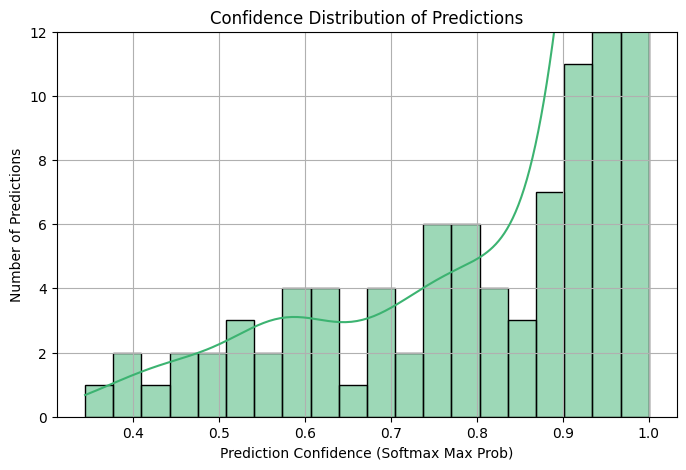

In [ ]:
# 📈 CONFIDENCE DISTRIBUTION
model.eval()
softmax_confidences = []

with torch.no_grad():
    for imgs, _ in val_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        max_probs = torch.max(probs, dim=1)[0].cpu().numpy()
        softmax_confidences.extend(max_probs)

# 📉 Plot Histogram
plt.figure(figsize=(8, 5))
sns.histplot(softmax_confidences, bins=20, kde=True, color='mediumseagreen')
plt.title("Confidence Distribution of Predictions")
plt.xlabel("Prediction Confidence (Softmax Max Prob)")
plt.ylabel("Number of Predictions")
plt.ylim(0, 12)  # 👈 Set max y-axis to 12
plt.grid(True)
plt.show()
